In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
from scipy import misc
import numpy as np
import scipy.io
import glob
import os
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [3]:
#load mat file
mat = scipy.io.loadmat('Path_to_the_mat_file')
mat.keys()

dict_keys(['__header__', '__globals__', '__version__', 'norm_chb08'])

In [4]:
#read the mat file
Data1 = mat['norm_chb08']
Data2  = np.array(Data1)
Data2.shape

(2, 1843200)

In [5]:
#Convert signal sampling rate to seconds
dak = Data2.shape[1]
dak = int(dak / (256))
dak

7200

In [6]:
# converting data into suitable format (7200 seconds preictal and interictal EEG signal)
Data3 = Data2.reshape(2, dak, 256)
Data4 = Data3.reshape(2*dak, 256,1)
Data3.shape, Data4.shape

((2, 7200, 256), (14400, 256, 1))

In [7]:
#Data labeling
y = np.zeros(2*dak)
y[dak:] = 1
y.shape

(14400,)

In [8]:
X = Data4
Y = y

In [12]:
%pylab inline
import os
import numpy as np
import pandas as pd
from scipy.misc import imread
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt 

import tensorflow as tf
import keras
import keras.backend as K

from capsulelayers1D import CapsuleLayer, PrimaryCap, Length, Mask
from keras import layers, models, optimizers

from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
K.set_image_data_format('channels_last')

Populating the interactive namespace from numpy and matplotlib


/vol/suat/suatEnvPY35/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['imread']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [13]:
def CapsNet(input_shape, n_class, routings):

   x = layers.Input(shape=(256,1))

   # Layer 1: Just a conventional Conv2D layer
   conv1 = layers.Conv1D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1')(x)

   # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
   primarycaps = PrimaryCap(conv1, dim_capsule=8, n_channels=32, kernel_size=5, strides=2, padding='valid')

   # Layer 3: Capsule layer. Routing algorithm works here.
   digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings,
   name='digitcaps')(primarycaps)

   # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
   # If using tensorflow, this will not be necessary. :)
   out_caps = Length(name='capsnet')(digitcaps)

   # Decoder network.
   y = layers.Input(shape=(n_class,))
   masked_by_y = Mask()([digitcaps, y]) # The true label is used to mask the output of capsule layer. For training
   masked = Mask()(digitcaps) # Mask using the capsule with maximal length. For prediction

   # Shared Decoder model in training and prediction
   decoder = models.Sequential(name='decoder')
   decoder.add(layers.Dense(512, activation='relu', input_dim=16*n_class))
   decoder.add(layers.Dense(1024, activation='relu'))
   decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
   decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

   # Models for training and evaluation (prediction)
   train_model = models.Model([x, y], [out_caps, decoder(masked_by_y)])
   eval_model = models.Model(x, [out_caps, decoder(masked)])

   # manipulate model
   noise = layers.Input(shape=(n_class, 16))
   noised_digitcaps = layers.Add()([digitcaps, noise])
   masked_noised_y = Mask()([noised_digitcaps, y])
   manipulate_model = models.Model([x, y, noise], decoder(masked_noised_y))
   return train_model, eval_model, manipulate_model


def margin_loss(y_true, y_pred):
   """
   Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
   :param y_true: [None, n_classes]
   :param y_pred: [None, num_capsule]
   :return: a scalar loss value.
   """
   L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
   0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

   return K.mean(K.sum(L, 1))

In [14]:
model, eval_model, manipulate_model = CapsNet(input_shape=(256,1),
                                              n_class=2, routings=3) #n_class=len(np.unique(np.argmax(train_y, 1))),

W0811 22:35:41.022411 140124176160576 deprecation_wrapper.py:119] From /vol/suat/suatEnvPY35/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:68: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0811 22:35:41.047011 140124176160576 deprecation_wrapper.py:119] From /vol/suat/suatEnvPY35/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:508: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0811 22:35:41.051123 140124176160576 deprecation_wrapper.py:119] From /vol/suat/suatEnvPY35/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:3837: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0811 22:35:41.221166 140124176160576 deprecation.py:506] From /vol/suat/Seizure/1D CapsNet/capsulelayers1D.py:93: calling softmax (from tensorflow.python.ops.nn_ops) with dim is deprecated and will be removed in a future version.
Instructions for upd

In [15]:
# compile the model
model.compile(optimizer=optimizers.Adam(lr=0.0001), loss=[margin_loss, 'mse'],
              loss_weights=[1., 0.392], metrics={'capsnet': 'accuracy'})

model.summary()

W0811 22:35:46.579068 140124176160576 deprecation_wrapper.py:119] From /vol/suat/suatEnvPY35/lib/python3.5/site-packages/keras/optimizers.py:757: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 1)       0                                            
__________________________________________________________________________________________________
conv1 (Conv1D)                  (None, 248, 256)     2560        input_1[0][0]                    
__________________________________________________________________________________________________
primarycap_conv1d (Conv1D)      (None, 122, 256)     327936      conv1[0][0]                      
__________________________________________________________________________________________________
primarycap_reshape (Reshape)    (None, 3904, 8)      0           primarycap_conv1d[0][0]          
__________________________________________________________________________________________________
primarycap

W0811 22:36:43.791505 140124176160576 deprecation.py:323] From /vol/suat/suatEnvPY35/lib/python3.5/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0811 22:36:44.496735 140124176160576 deprecation_wrapper.py:119] From /vol/suat/suatEnvPY35/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:977: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0811 22:36:44.693356 140124176160576 deprecation_wrapper.py:119] From /vol/suat/suatEnvPY35/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:964: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 11520 samples, validate on 2880 samples
Epoch 1/10
11520/11520 [==============================] - 37s 3ms/step - loss: 0.2081 - capsnet_loss: 0.2068 - decoder_loss: 0.0032 - capsnet_acc: 0.5863 - val_loss: 0.4119 - val_capsnet_loss: 0.4108 - val_decoder_loss: 0.0027 - val_capsnet_acc: 0.4837
Epoch 2/10
11520/11520 [==============================] - 34s 3ms/step - loss: 0.0868 - capsnet_loss: 0.0855 - decoder_loss: 0.0032 - capsnet_acc: 0.8946 - val_loss: 0.2475 - val_capsnet_loss: 0.2464 - val_decoder_loss: 0.0027 - val_capsnet_acc: 0.4542
Epoch 3/10
11520/11520 [==============================] - 34s 3ms/step - loss: 0.0663 - capsnet_loss: 0.0651 - decoder_loss: 0.0032 - capsnet_acc: 0.9278 - val_loss: 0.1598 - val_capsnet_loss: 0.1588 - val_decoder_loss: 0.0026 - val_capsnet_acc: 0.6587
Epoch 4/10
11520/11520 [==============================] - 34s 3ms/step - loss: 0.0444 - capsnet_loss: 0.0432 - decoder_loss: 0.0032 - capsnet_acc: 0.9532 - val_loss: 0.2348 - val_capsnet_loss:

/vol/suat/suatEnvPY35/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


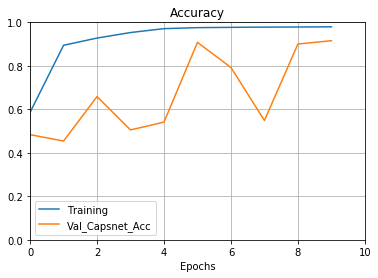

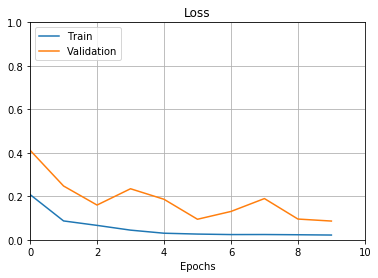

--------------------------------------------------
Test acc: 0.915625

Confusion Matrix: 
 [[1422   18]
 [ 225 1215]]
Fold Score: [0.08621100923563871, 0.08518420716799381, 0.002619393069471698, 0.915625]
Train on 11520 samples, validate on 2880 samples
Epoch 1/10
11520/11520 [==============================] - 36s 3ms/step - loss: 0.2291 - capsnet_loss: 0.2280 - decoder_loss: 0.0028 - capsnet_acc: 0.5128 - val_loss: 0.1976 - val_capsnet_loss: 0.1959 - val_decoder_loss: 0.0044 - val_capsnet_acc: 0.6896
Epoch 2/10
11520/11520 [==============================] - 34s 3ms/step - loss: 0.1315 - capsnet_loss: 0.1304 - decoder_loss: 0.0027 - capsnet_acc: 0.7989 - val_loss: 0.0996 - val_capsnet_loss: 0.0979 - val_decoder_loss: 0.0044 - val_capsnet_acc: 0.8535
Epoch 3/10
11520/11520 [==============================] - 34s 3ms/step - loss: 0.0827 - capsnet_loss: 0.0816 - decoder_loss: 0.0026 - capsnet_acc: 0.8886 - val_loss: 0.0648 - val_capsnet_loss: 0.0633 - val_decoder_loss: 0.0039 - val_capsnet

/vol/suat/suatEnvPY35/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


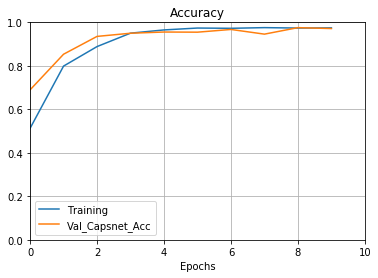

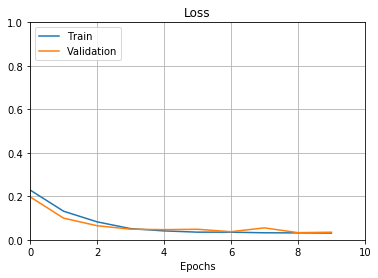

--------------------------------------------------
Test acc: 0.9715277777777778

Confusion Matrix: 
 [[1431    9]
 [  73 1367]]
Fold Score: [0.03488444469662176, 0.03361167330682899, 0.003246866515514234, 0.9715277777777778]
Train on 11520 samples, validate on 2880 samples
Epoch 1/10
11520/11520 [==============================] - 36s 3ms/step - loss: 0.2295 - capsnet_loss: 0.2282 - decoder_loss: 0.0033 - capsnet_acc: 0.4985 - val_loss: 0.2143 - val_capsnet_loss: 0.2134 - val_decoder_loss: 0.0023 - val_capsnet_acc: 0.5115
Epoch 2/10
11520/11520 [==============================] - 34s 3ms/step - loss: 0.1788 - capsnet_loss: 0.1775 - decoder_loss: 0.0033 - capsnet_acc: 0.6756 - val_loss: 0.0788 - val_capsnet_loss: 0.0779 - val_decoder_loss: 0.0023 - val_capsnet_acc: 0.9472
Epoch 3/10
11520/11520 [==============================] - 34s 3ms/step - loss: 0.1190 - capsnet_loss: 0.1177 - decoder_loss: 0.0032 - capsnet_acc: 0.8142 - val_loss: 0.0442 - val_capsnet_loss: 0.0433 - val_decoder_loss: 

/vol/suat/suatEnvPY35/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


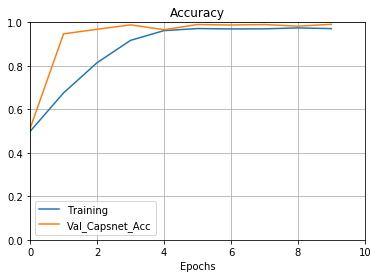

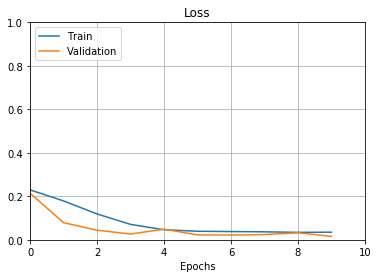

--------------------------------------------------
Test acc: 0.9909722222222223

Confusion Matrix: 
 [[1436    4]
 [  22 1418]]
Fold Score: [0.015811371573040054, 0.01500735669138117, 0.0020510584148319645, 0.9909722222222223]
Train on 11520 samples, validate on 2880 samples
Epoch 1/10
11520/11520 [==============================] - 36s 3ms/step - loss: 0.2288 - capsnet_loss: 0.2275 - decoder_loss: 0.0034 - capsnet_acc: 0.5052 - val_loss: 0.2079 - val_capsnet_loss: 0.2071 - val_decoder_loss: 0.0020 - val_capsnet_acc: 0.5000
Epoch 2/10
11520/11520 [==============================] - 34s 3ms/step - loss: 0.1531 - capsnet_loss: 0.1518 - decoder_loss: 0.0033 - capsnet_acc: 0.7429 - val_loss: 0.0429 - val_capsnet_loss: 0.0421 - val_decoder_loss: 0.0020 - val_capsnet_acc: 0.9767
Epoch 3/10
11520/11520 [==============================] - 34s 3ms/step - loss: 0.0885 - capsnet_loss: 0.0872 - decoder_loss: 0.0033 - capsnet_acc: 0.8844 - val_loss: 0.0262 - val_capsnet_loss: 0.0254 - val_decoder_loss

/vol/suat/suatEnvPY35/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


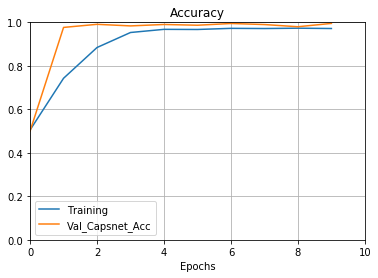

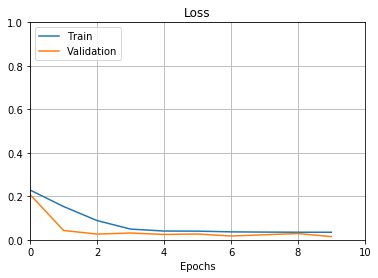

--------------------------------------------------
Test acc: 0.9951388888888889

Confusion Matrix: 
 [[1435    5]
 [   9 1431]]
Fold Score: [0.014725042416507171, 0.014061571727506817, 0.0016925274704893431, 0.9951388888888889]
Train on 11520 samples, validate on 2880 samples
Epoch 1/10
11520/11520 [==============================] - 36s 3ms/step - loss: 0.2238 - capsnet_loss: 0.2226 - decoder_loss: 0.0029 - capsnet_acc: 0.5352 - val_loss: 0.2050 - val_capsnet_loss: 0.2034 - val_decoder_loss: 0.0040 - val_capsnet_acc: 0.5017
Epoch 2/10
11520/11520 [==============================] - 34s 3ms/step - loss: 0.1325 - capsnet_loss: 0.1314 - decoder_loss: 0.0029 - capsnet_acc: 0.7925 - val_loss: 0.0930 - val_capsnet_loss: 0.0915 - val_decoder_loss: 0.0039 - val_capsnet_acc: 0.8719
Epoch 3/10
11520/11520 [==============================] - 34s 3ms/step - loss: 0.0889 - capsnet_loss: 0.0878 - decoder_loss: 0.0028 - capsnet_acc: 0.8748 - val_loss: 0.0622 - val_capsnet_loss: 0.0607 - val_decoder_los

/vol/suat/suatEnvPY35/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


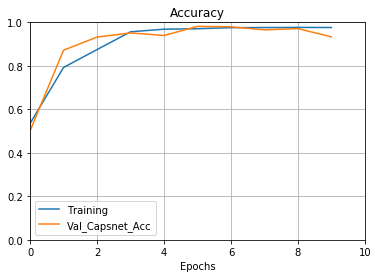

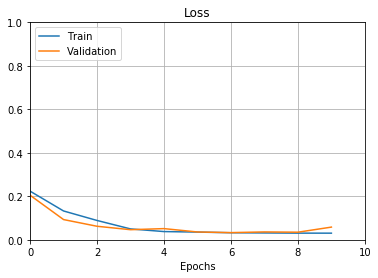

--------------------------------------------------
Test acc: 0.9333333333333333

Confusion Matrix: 
 [[1252  188]
 [   4 1436]]
Fold Score: [0.058370306808501485, 0.057014887790299125, 0.0034577016479387466, 0.9333333333333333]
96.13% (+/- 3.16%)


In [16]:
# define 5-fold cross validation 

kfold = StratifiedKFold(n_splits=5, shuffle=False)
cvscores = []

for train, test in kfold.split(X, Y):
    
    Y_cat = to_categorical(Y)
    model, eval_model, manipulate_model = CapsNet(input_shape=X[train].shape[1:], n_class=2, routings=3) 
    # compile the model
    model.compile(optimizer=optimizers.Adam(lr=0.0001), loss=[margin_loss, 'mse'], 
                  loss_weights=[1., 0.392], metrics={'capsnet': 'accuracy'})
    #model.summary()
    
    trained_model3 = model.fit([X[train],Y_cat[train]], [Y_cat[train], X[train]], batch_size=16, epochs=10,
                               validation_data=[[X[test], Y_cat[test]], [Y_cat[test], X[test]]])
    
    
   
     #draw the Accuracy graph
    res = plt.figure()
    csfont = {'fontname':'Times'}
    plt.plot(trained_model3.history['capsnet_acc'])
    plt.plot(trained_model3.history['val_capsnet_acc'])
    plt.legend(['Training', 'Val_Capsnet_Acc'])
    plt.title('Accuracy' , **csfont)
    plt.xlabel('Epochs' , **csfont)
    plt.axis([0, 10, .0, 1])
    plt.grid(True)
    plt.show()
   
    
    #draw the Loss graph
    res1 = plt.figure()
    plt.plot(trained_model3.history['loss'])
    plt.plot(trained_model3.history['val_loss'])
    plt.title('Loss' , **csfont)
    #plt.ylabel('loss')
    plt.xlabel('Epochs' , **csfont)
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.axis([0, 10, .0, 1])
    plt.grid(True)
    plt.show()
    

    y_pred, x_recon = model.predict([X[test],Y_cat[test]], batch_size=16 )
    print('-'*50)
    print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(Y_cat[test], 1))/Y_cat[test].shape[0])  
    
    print("\nConfusion Matrix: \n",confusion_matrix(Y[test], np.argmax(y_pred, axis=1)))
    #print("y_pred Shape:", np.array(y_pred).shape)
    print("Fold Score:", model.evaluate([X[test],Y_cat[test]],[Y_cat[test],X[test]], verbose=0))
    
    scores = model.evaluate([X[test],Y_cat[test]],[Y_cat[test],X[test]], verbose=0)
    cvscores.append(scores[3] * 100)
    
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))


# Reconstruction

In [62]:
def test(model, data):
    x_test, y_test = data
    y_pred, x_recon = model.predict(x_test, batch_size=64)
    print('-'*50)
    print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1))/y_test.shape[0])
    import matplotlib.pyplot as plt
    plt.figure()
    plt.subplot(211)
    plt.plot(x_recon[16], 'b-')
    plt.title('Reconstruction')
    
    plt.figure()
    plt.subplot(212)  
    plt.plot(x_test[16])
    plt.title('Original')

--------------------------------------------------
Test acc: 0.98


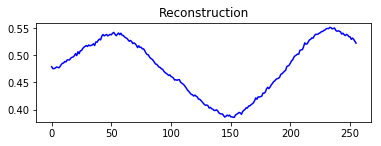

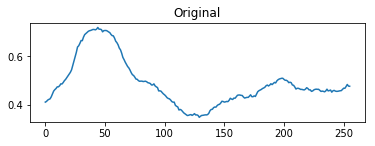

In [63]:
test(model=eval_model, data=(x_test[:50], y_test[:50]))